In [19]:
import numpy as np
import scipy as sp
import scipy.linalg as spla
import scipy.sparse as sps
import math
from importlib import reload

#Load various data and functions
import fundamental_gates #Useful single qutrit gates
reload(fundamental_gates)
from fundamental_gates import *

import interaction_and_decay #parameters - change dephasing rates in here
reload(interaction_and_decay)
from interaction_and_decay import *

import embed_functions #functions to embed 1/2-qutrit objects into many-qutrit operators
reload(embed_functions)
from embed_functions import *

import gate_sequences #gate sequences for various gates we've discussed - ZZ4 gate sequence is the one actually used in expt
reload(gate_sequences)
from gate_sequences import *

import evolution #functions to calculate evolution of initial state under gate sequence
reload(evolution)
from evolution import *

import EPR_preparation_data #experimental density matrices for EPR prep
reload(EPR_preparation_data)
from EPR_preparation_data import EPR_init_07, EPR_init_56

In [13]:
###
# Just some setup
# Notation:
# Qutrit ordering 1 (<- psi) 0 7 (<- BH EPR) 6 5 (<- Ancillary EPR)
# Often use 0 1 2 3 4 instead for qutrit indexing in code
# State ordering 0 1 2 = G E F
###

#Remember: expt data is not taking into account residual entanglement between 07 and 56 EPR pairs - would require too much tomography
rho_EPR_56_expt = sps.csr_matrix(EPR_init_56)
rho_EPR_07_expt = sps.csr_matrix(EPR_init_07)

#2-qutrit EPR, get fidelities
state_EPR = np.asarray([1.,0,0,   0,1.,0,   0,0,1.])/np.sqrt(3)
rho_EPR = sps.kron(state_EPR,state_EPR.conj()).T.reshape((9,9))
F_EPR_56 = np.trace(EPR_init_56.dot(rho_EPR.todense()))
F_EPR_07 = np.trace(EPR_init_07.dot(rho_EPR.todense()))

#Print EPR fidelities of experimental density matrices
print("F_EPR_56: " + str(F_EPR_56))
print("F_EPR_07: " + str(F_EPR_07))

###
# Some useful states
###
#Single qutrit 2-design of states
state_0 = np.asarray([1.,0,0])
states = [state_0, X.dot(state_0), X.dot(X.dot(state_0))]
states = states + [Hadamard.dot(state) for state in states] + [Hadamard_a1.dot(state) for state in states] + [Hadamard_a2.dot(state) for state in states]
#2-qutrit EPR
state_EPR = np.asarray([1.,0,0,   0,1.,0,   0,0,1.])/np.sqrt(3)
state_EPR_a = np.asarray([1.,0,0,   0,0,1.,   0,1.,0])/np.sqrt(3)
rho_EPR = sps.kron(state_EPR,state_EPR.conj()).T.reshape((9,9))
rho_EPR_a = sps.kron(state_EPR_a,state_EPR_a.conj()).T.reshape((9,9))

F_proj_EPR = .92
proj_EPR = F_proj_EPR*rho_EPR 

F_EPR_56: (0.8187653466666669+5.204170427930421e-18j)
F_EPR_07: (0.841173176666667-1.0408340855860843e-17j)


In [28]:
###
# Run everything here!
###

reload(gate_sequences)

#Function to perform teleportation protocol
def getPandF(gatelist,psi,rho_EPR_07,rho_EPR_56,F_EPR_meas,decoh = True,dephas = True):
    """
    gatelist: list of gates
    psi: initial state to be teleported
    rho_EPR_07: 9 x 9 density matrix for 07 initial EPR pair
    rho_EPR_56: 9 x 9 density matrix for 56 initial EPR pair
    F_EPR_meas: fidelity of EPR measurement - currently assumes measurement is composition of depolarizing channel + perfect measurement, for simplicity
    decoh: Boolean
    RETURNS:
    P_psi: probability of successful EPR projection
    F_psi: fidelity of teleportation after EPR post-selection
    """
    ###
    # Setup initial state
    ###
    q_list = [1,0,7,6,5]
    rho_psi = sps.kron(psi,psi.conj().T).reshape((3,3))
    rho_init = sps.kron(sps.kron(rho_psi,rho_EPR_07),rho_EPR_56).reshape((59049,1))
    ###
    # Evolve the state
    ###
    rho_final = actFullGateOnState(gatelist,rho_init, q_list , num_trot = 10, decoh = decoh,dephas = dephas)
    ###
    # Get P and F from final state
    ###
    
    #EPR measurement = depolarizing channel + EPR projection
    #depolarizing - naively would guess this affects F (in ideal case) to be F_EPR_meas + (1-F_EPR_meas)*(1/9 + 8/9 * 1/3) - seems to do ~ a percent worse than this
    p = 1 - np.sqrt(F_EPR_meas) #sqrt because we are doing it twice - once on qutrit 0 and once on qutrit 7
    rho_final = depol_channel(rho_final,p,1) #0 & 7 labels are qutrits 1 & 2
    rho_final = depol_channel(rho_final,p,2)
    #Reshape rho
    rho_final = rho_final.reshape((243,243))
    #Perform EPR projection
    EPR_meas_full = sps.kron(sps.kron(sps.eye(3),rho_EPR),sps.eye(3**2)) #projector operator
    
    P_psi = rho_final.dot(EPR_meas_full).diagonal().sum()
    rho_postselect = EPR_meas_full.dot(rho_final.dot(EPR_meas_full))/P_psi

    rho_psi_5 = sps.kron(sps.eye(3**4),rho_psi) #projector operator
    F_psi = rho_postselect.dot(rho_psi_5).diagonal().sum()
    
    return P_psi,F_psi

###
# Input parameters
###

#Ideal:
# rho_EPR_07 = rho_EPR
# rho_EPR_56 = rho_EPR
# F_EPR_meas = 1.
# decoh = False
# dephas = False

# Actual:
rho_EPR_07 = rho_EPR_07_expt
rho_EPR_56 = rho_EPR_56_expt
F_EPR_meas = .92
decoh = True
dephas = False

psi_idx_list = range(12) #Run for all 12 2-design states - list of 2-design states generated in previous cell
# psi_idx_list = [4,11] #Run for just a few states to get a quicker feel for teleportation fidelity

#Perform protocol for each state in psi_idx_list
P_list = []
F_list = []
print("ZZ4 Teleportation protocol fidelities: \n")
for psi_idx in psi_idx_list:
    psi = states[psi_idx]
    P_psi, F_psi = getPandF(gate_sequences.standard_scrambler_gatelist,psi,rho_EPR_07,rho_EPR_56,F_EPR_meas,decoh = decoh,dephas = dephas)
    P_list.append(P_psi.real)
    F_list.append(F_psi.real)
    #print("State " + str(psi_idx) + " out of 12:")
    #print("P = " + str(P_psi))
    #print("F = " + str(F_psi) + "\n\n")

print("P_psi = " + str(P_list))
print("F_psi = " + str(F_list))
print("<P> = " + str(np.array(P_list).mean()))
print("<F> = {}".format(np.array(F_list).mean()))
print("<FP>/<P> = " + str((np.array(P_list)*np.array(F_list)).mean()/np.array(P_list).mean()) + "\n\n")



ZZ4 Teleportation protocol fidelities: 

P_psi = [0.12342731324850198, 0.10401868648553532, 0.10588903394895766, 0.11346465923393645, 0.11237099529799596, 0.10749937915106263, 0.11106635907168229, 0.1142829054328148, 0.107985769178498, 0.12076724131123388, 0.10828889099828312, 0.10427890137347812]
F_psi = [0.7299622486235589, 0.6476235290237634, 0.665610919536328, 0.6591579523793164, 0.6609943093691478, 0.6033921616459099, 0.6389346725824194, 0.7036465571176392, 0.61045130856398, 0.7083912723988087, 0.655776669834344, 0.6137619228167174]
<P> = 0.11111167789433168
<F> = 0.6581419603243278
<FP>/<P> = 0.659801867364722




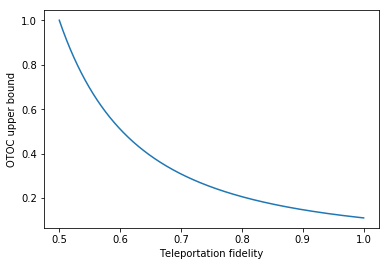

In [18]:
###
# Plot of theoretical bound on OTOC given typical teleportation fidelity
###

import numpy as np
from matplotlib import pyplot as plt

F = np.linspace(1/2.,1.,1000)
OTOC_bound = 1./(4*F-1)**2

f = plt.figure()
plt.plot(F,OTOC_bound)
plt.xlabel("Teleportation fidelity")
plt.ylabel("OTOC upper bound")

plt.show()

#f.savefig("OTOC_bound_qutrit.pdf", bbox_inches='tight')